In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from lime import lime_tabular
import lime

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# regressors

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline
sns.set()

In [2]:
data = pd.read_csv('../datasets/train_casa.csv', na_values='?').drop(0, axis = 0).reset_index(drop = True)

In [3]:
data.head()

,Id,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,6236,-117.74,34.06,48,2438,599,1508,548,28983,129200
1,19262,-118.11,33.92,32,1016,190,729,177,43000,151300
2,19743,-118.12,34.15,35,1760,447,984,384,34167,198200
3,7272,-120.63,37.41,27,2083,444,1462,479,26439,69100
4,1155,-121.43,38.54,42,3321,688,1346,658,24618,101300


In [4]:
data.shape

(14447, 10)

In [5]:
from sklearn.preprocessing import MinMaxScaler

def plotMap(data, sizes = None, colors = None, cmap = 'Wistia', alpha = 0.7, title = 'Mapa'):
    '''
    plot on cartesian plan, coordinatedes according to lat long, with circle sizes em color scale
    '''
    v_sizes, v_colors = None, None
    if sizes is not None:
        scaler = MinMaxScaler()
        v_sizes = scaler.fit_transform(data[sizes].values.reshape(-1,1))*100
        v_sizes = v_sizes.reshape(-1)
        
    if colors is not None:
        v_colors = data[colors]
        
    with plt.style.context('default'):
        data.plot.scatter('longitude', 'latitude', s = v_sizes, figsize = (11,7), c = v_colors, cmap = cmap, alpha = alpha)
        plt.title(title)

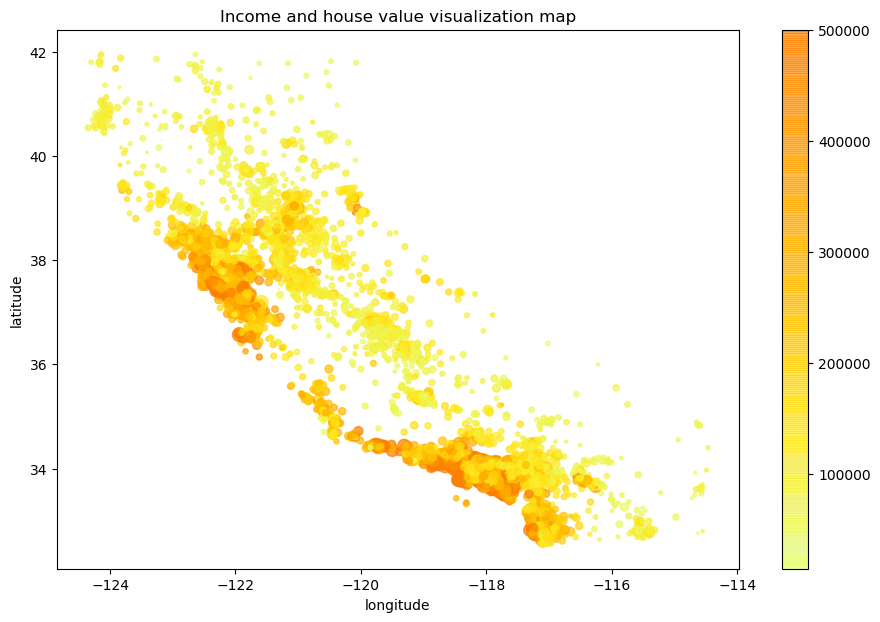

In [6]:
plotMap(data, sizes = 'median_income', colors = 'median_house_value', title = 'Income and house value visualization map')

**Conclusão**: A população litorânea além de receberem mais do que a população do interior, o valor das casas tabém é superior.

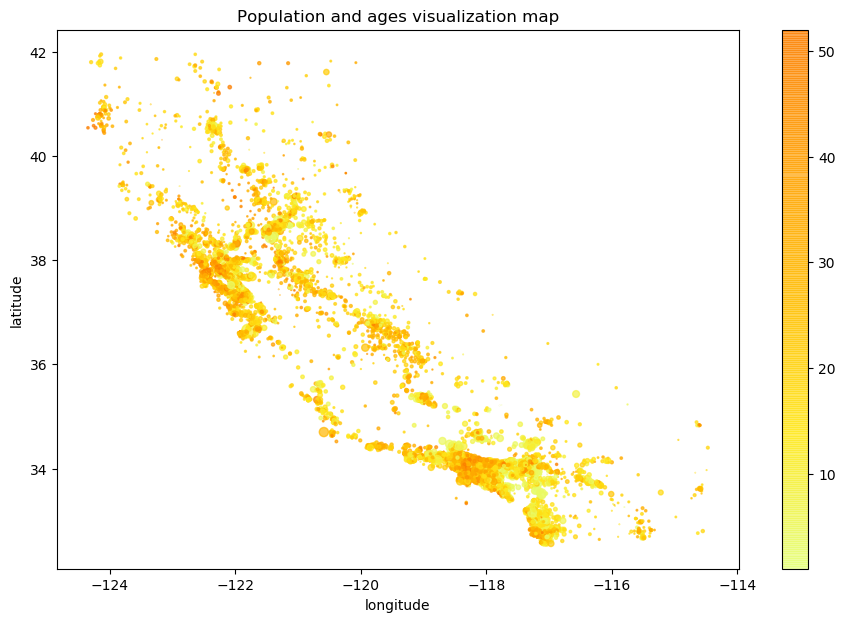

In [7]:
plotMap(data, sizes = 'population', colors = 'median_age', title = 'Population and ages visualization map', alpha = 0.7)

**Conslusão**: Ao sul podemos observar um cluster, que nele à noroeste, a população é mais velha que à sudeste. A população central é muito baixa (vemos grandes vazios -- desertos) e bolas muito pequenas. Ao norte, temos uma população bastante mista em idades, mas com densidade superior no litoral.

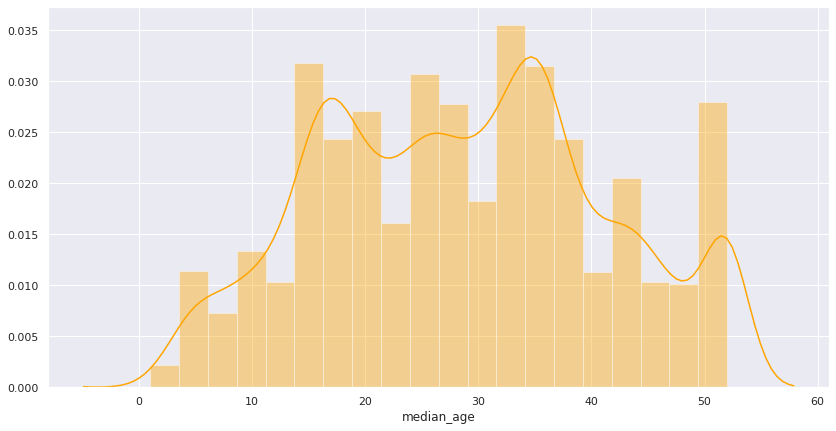

In [8]:
plt.figure(figsize=(14,7))
sns.distplot(data['median_age'], color = 'Orange', bins = 20)

**Conclusão**: Pirâmide etária com base infantil (0 - 13) muito pequena, grande maioria adultos (21 - 55).

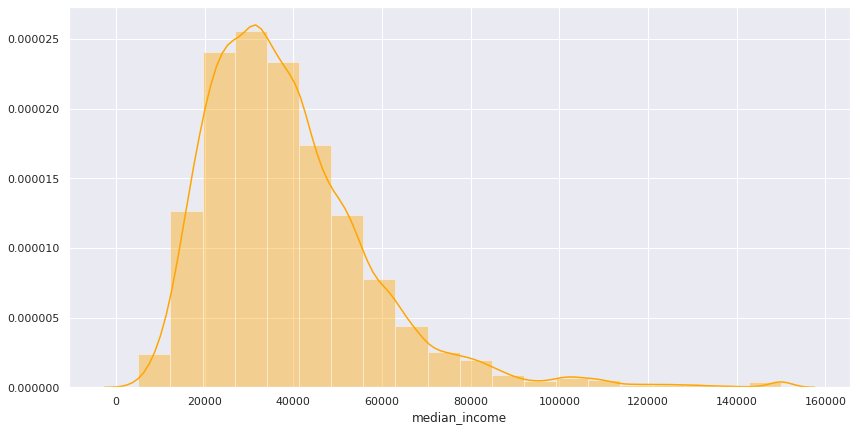

In [9]:
plt.figure(figsize=(14,7))
sns.distplot(data['median_income'], color = 'Orange', bins = 20)

**Conclusão**: Uma distribuição do tipo beta, com uma cauda longa à direita. Poucos recebem muito, e a grande parte da população recebe próximo à mediana.

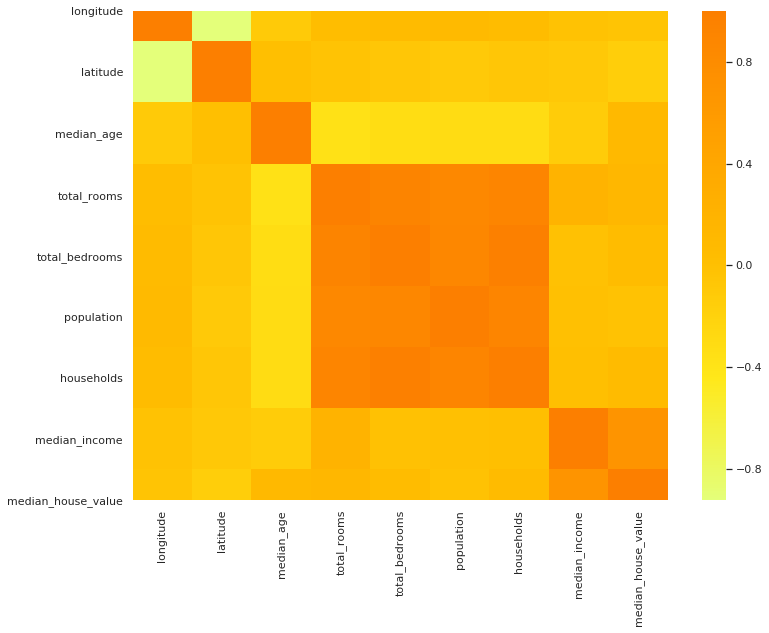

In [10]:
corrmat = data.drop('Id', axis = 1).corr()
plt.figure(figsize=(12,9))
sns.heatmap(corrmat, cmap = 'Wistia')

**Conclusão**: Vemos uma grande correlação entre alguns fatores como (lat, long); entre os pares de [salas, quartos, população, casas]; além disso, forte correlação positiva entre a o salário e o valor das casas.

In [72]:
def longitudeCorrection(values):
    return np.cos((values+122)/1.2)**2

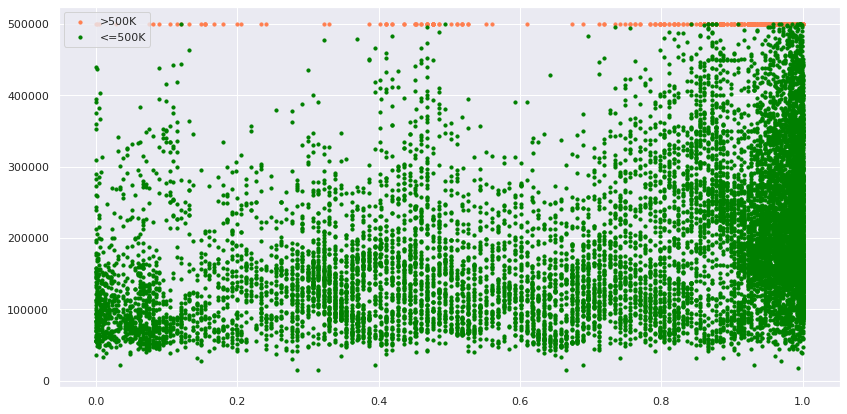

In [78]:
plt.figure(figsize=(14,7))
var_x = 'longitude'
var_y = 'median_house_value'




aux1 = data[data['median_house_value'] == 500001]
x_ = longitudeCorrection(aux1[var_x])
y_ = aux1[var_y]

aux2 = data[data['median_house_value'] != 500001]
x__ = longitudeCorrection(aux2[var_x])
y__ = aux2[var_y]

plt.scatter(x_, y_, s = 10, c = 'coral', label = '>500K')
plt.scatter(x__, y__, s = 10, c = 'green', label = '<=500K')
plt.legend()

In [69]:
temp = data.sort_values(var_y)
temp

,Id,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13061,9801,-117.02,36.40,19,619,239,490,164,21000,14999
8345,6662,-123.17,40.31,36,98,28,18,8,5360,14999
9389,3579,-122.74,39.71,16,255,73,85,38,16607,14999
264,16847,-118.33,34.15,39,493,168,259,138,23666,17500
9317,784,-117.16,32.71,52,845,451,1230,375,10918,22500
...,...,...,...,...,...,...,...,...,...,...
227,8963,-122.43,37.79,52,6186,1566,2065,1374,58543,500001
978,19155,-118.68,34.08,18,102,17,55,21,39934,500001
2694,3998,-118.46,33.77,28,3065,406,1101,391,105536,500001
11899,9954,-122.35,37.57,52,2170,269,784,274,104286,500001


In [80]:
data['class_value'] = data['median_house_value'] == 500001

/home/lucasnseq/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucasnseq/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


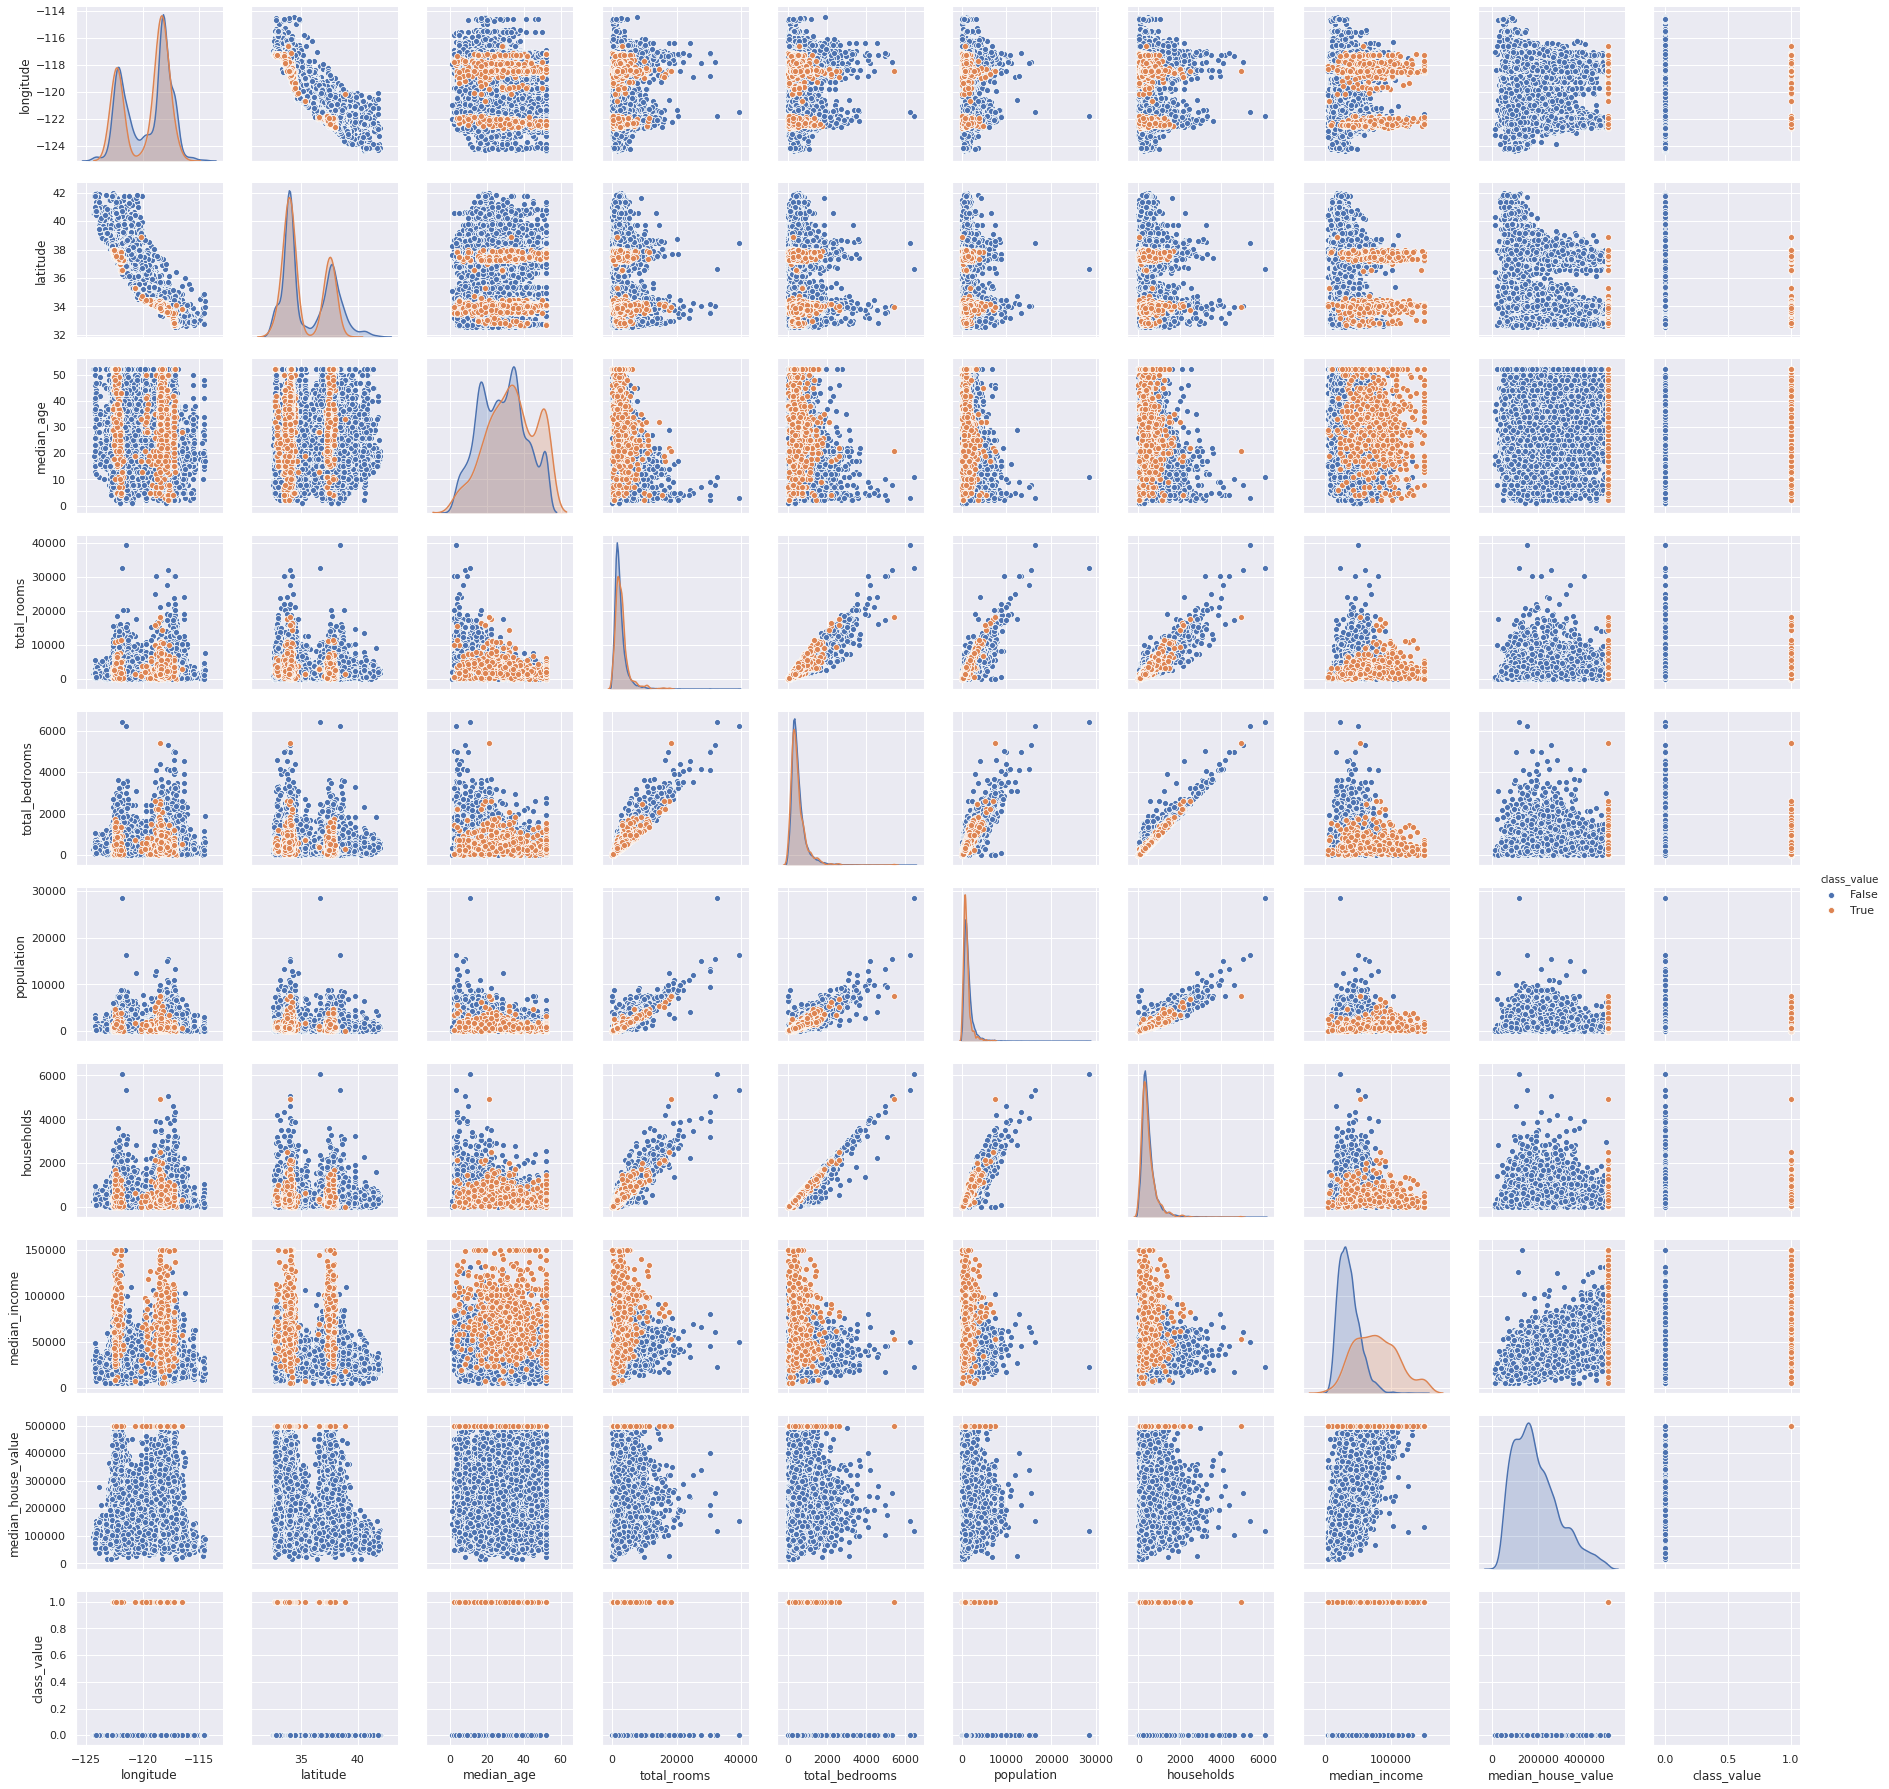

In [84]:
sns.pairplot(data.drop('Id', axis = 1), hue = 'class_value')

In [160]:
data.columns

Index(['Id', 'longitude', 'latitude', 'median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'class_value'],
      dtype='object')

In [126]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [161]:
columns = ['longitude', 'latitude', 'median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
target = 'class_value'
X, y = data[columns], data[target]

X, y = X.values, y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

clf = KNeighborsClassifier(n_neighbors=4)
clfCV = cross_val_score(clf, X_train, y_train, cv = 10)
clfCV.mean()

0.961827799345539

In [162]:
clf.fit(X_train, y_train)
ans = clf.predict(X_test)
k = sum(ans == y_test)/len(ans)
k

0.9607843137254902

In [163]:
f1_score(y_test, ans)

0.44444444444444436

Outliers

In [50]:
from scipy import stats

#Retirando outliers da base
data_clean = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

#Reindexando para ajustar termos faltantes
data_clean = data_clean.assign(index = list(range(0, data_clean.iloc[:,0].size)))
data_clean = data_clean.set_index('index')
data_clean

,Id,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
index,,,,,,,,,,
0,6236,-117.74,34.06,48,2438,599,1508,548,28983,129200
1,19262,-118.11,33.92,32,1016,190,729,177,43000,151300
2,19743,-118.12,34.15,35,1760,447,984,384,34167,198200
3,7272,-120.63,37.41,27,2083,444,1462,479,26439,69100
4,1155,-121.43,38.54,42,3321,688,1346,658,24618,101300
...,...,...,...,...,...,...,...,...,...,...
13786,7044,-117.21,32.75,15,1716,702,914,672,10612,300000
13787,10154,-121.18,38.78,13,3480,528,1432,532,61642,277800
13788,12871,-121.33,38.65,23,2446,523,1132,513,26266,198500


In [51]:
selected_columns = ['longitude', 'median_income', 'median_age', 'population']
target = 'median_house_value'

if 'longitude' in selected_columns:
    data_clean['longitude'] = np.cos((data_clean['longitude']+122)/1.2)**2

selected_base = pd.concat([data_clean[selected_columns], data_clean[target]], axis = 1)

In [52]:
scaler = {}
for col in selected_columns:
    scaler[col] = StandardScaler()
    selected_base[col] = scaler[col].fit_transform(selected_base[col].values.reshape(-1,1))
    
scaler[target] = MinMaxScaler()
selected_base[target] = scaler[target].fit_transform(selected_base[target].values.reshape(-1,1))

In [53]:
X, y = selected_base[selected_columns].values, selected_base[target].values

In [54]:
from sklearn.metrics import mean_squared_error, make_scorer

msle = make_scorer(mean_squared_error)

Linear regression

In [55]:
%%time

# train

LinReg = LinearRegression()

LinCV = cross_val_score(LinReg, X, y.reshape(-1), cv = 10, scoring = msle)

LinReg.fit(X, y)

cv_accuracy = [LinCV.mean()]
cv_std = [LinCV.std()]
cv_values = {}
cv_values['Lin'] = LinCV
print('Linear Regression CV msle: {0:1.4f} +-{1:2.5f}\n'.format(LinCV.mean(), LinCV.std()))

Linear Regression CV msle: 0.0265 +-0.00083

CPU times: user 32.9 ms, sys: 11 µs, total: 32.9 ms
Wall time: 31.5 ms


In [56]:
%%time

# train

KNNReg = KNeighborsRegressor(n_neighbors=30)

KNNCV = cross_val_score(KNNReg, X, y, cv = 10, scoring = msle)

KNNReg.fit(X, y)

cv_accuracy.append(KNNCV.mean())
cv_std.append(KNNCV.std())
cv_values['KNN'] = KNNCV
print('KNN Regression CV msle: {0:1.4f} +-{1:2.5f}\n'.format(KNNCV.mean(), KNNCV.std()))

KNN Regression CV msle: 0.0240 +-0.00060

CPU times: user 248 ms, sys: 45 µs, total: 248 ms
Wall time: 247 ms


In [57]:
%%time

# train

RFReg = RandomForestRegressor(n_estimators = 50, max_depth = 14)

RFCV = cross_val_score(RFReg, X, y.reshape(-1), cv = 10, scoring = msle)

RFReg.fit(X, y.reshape(-1))

cv_accuracy.append(RFCV.mean())
cv_std.append(RFCV.std())
cv_values['RF'] = RFCV
print('RF Regression CV msle: {0:1.4f} +-{1:2.5f}\n'.format(RFCV.mean(), RFCV.std()))

RF Regression CV msle: 0.0232 +-0.00064

CPU times: user 14 s, sys: 3.74 ms, total: 14 s
Wall time: 14 s


In [20]:
results = pd.DataFrame()

results['Estimator'] = ['Linear Regression', 'K-Nearest Neighboors Regressor', 'Random Forest Regressor']
results['CV accuracy'] = cv_accuracy
results['CV std'] = cv_std
results['~Time (Train) [ms]'] = [35, 265, 1440]

results = results.set_index('Estimator', drop = True)

# setting CV values for visualization

cv_values = pd.DataFrame(cv_values)
cv_values = np.concatenate([cv_values.columns.values.reshape(-1,1), cv_values.values.transpose()], axis = 1)
temp = {}
for u in range(cv_values.shape[0]):
    temp[u] = cv_values[u, :]
cv_values = pd.DataFrame(temp)
cv_values = cv_values.rename(columns = {0:'Linear Regression', 1:'K-Nearest Neighboors Regressor', 2:'Random Forest Regressor'})
cv_values = cv_values.drop(0, axis = 0)

NameError: name 'cv_accuracy' is not defined

In [ ]:
plt.figure(figsize=(14,7))
plt.title('Cross Validation MSLE', fontsize = 15)
sns.boxplot(data = cv_values, palette = 'Wistia')

In [ ]:
plt.figure(figsize=(14,7))
plt.title('~Time Evaluation [ms]', fontsize = 15)
plt.plot(results.index, results['~Time (Train) [ms]'].values, color = 'gray', lw = 2,
         marker = 'o', markersize = 12, markerfacecolor = 'orange', label = 'Train')
plt.legend()